In [8]:
# === Hybrid Transformer-LSTM for Forex Forecasting ===
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os

In [9]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")



✅ Using device: cuda


In [10]:
# === Parameters ===
symbols = ['USDJPY=X', 'EURUSD=X', 'GBPUSD=X']
clean_names = ['USDJPY', 'EURUSD', 'GBPUSD']
features = [
    'Close', 'MA10', 'MA50', 'EMA10', 'EMA50', 'STD20',
    'Bollinger_Width', 'RSI', 'MOM', 'MACD', 'ATR'
]

# === Feature Engineering ===
def compute_features(data):
    data['MA10'] = data['Close'].rolling(10).mean()
    data['MA50'] = data['Close'].rolling(50).mean()
    data['EMA10'] = data['Close'].ewm(span=10).mean()
    data['EMA50'] = data['Close'].ewm(span=50).mean()
    data['STD20'] = data['Close'].rolling(20).std()
    data['Bollinger_High'] = data['MA10'] + 2 * data['STD20']
    data['Bollinger_Low'] = data['MA10'] - 2 * data['STD20']
    data['Bollinger_Width'] = data['Bollinger_High'] - data['Bollinger_Low']
    pct_change = data['Close'].pct_change()
    data['RSI'] = 100 - (100 / (1 + pct_change.rolling(14).mean() / pct_change.rolling(14).std()))
    data['MOM'] = data['Close'].diff(10)
    data['MACD'] = data['Close'].ewm(span=12).mean() - data['Close'].ewm(span=26).mean()
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    data['ATR'] = tr.rolling(14).mean()
    return data[features].dropna()

fx_data = {s: compute_features(yf.download(s, period="10y", interval="1d")) for s in symbols}
min_len = min(len(df) for df in fx_data.values())
aligned = [fx_data[s][-min_len:].to_numpy() for s in symbols]
fx_combined = np.stack(aligned, axis=1).transpose(1, 0, 2)
df_dict = {name: pd.DataFrame(fx_combined[i], columns=features) for i, name in enumerate(clean_names)}
print("✅ Data loaded and processed.")

/tmp/ipykernel_14394/3254113941.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = {s: compute_features(yf.download(s, period="10y", interval="1d")) for s in symbols}
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_14394/3254113941.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = {s: compute_features(yf.download(s, period="10y", interval="1d")) for s in symbols}
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_14394/3254113941.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = {s: compute_features(yf.download(s, period="10y", interval="1d")) for s in symbols}
[*********************100%***********************]  1 of 1 completed

✅ Data loaded and processed.


In [11]:
# Ensure output directory exists
os.makedirs("saved_models", exist_ok=True)
os.makedirs("figures", exist_ok=True)
os.makedirs("predictions_csv", exist_ok=True)

In [12]:
# === Hybrid Transformer-LSTM Model ===
class HybridModel(nn.Module):
    def __init__(self, input_dim, seq_len=60, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.lstm = nn.LSTM(d_model, 32, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

def create_sequences(data, seq_len=60):
    X = np.array([data[i:i+seq_len] for i in range(len(data) - seq_len)])
    y = data[seq_len:, 0]  # Predict Close
    return X, y

# === Training ===
currency_models = {}
currency_scalers = {}
currency_predictions = {}

for pair in clean_names:
    print(f"\n🚀 Training {pair}")
    df = df_dict[pair].copy()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    X, y = create_sequences(scaled, seq_len=60)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y[:, None], dtype=torch.float32)

    ds = TensorDataset(X_tensor, y_tensor)
    dl = DataLoader(ds, batch_size=64, shuffle=True)

    model = HybridModel(input_dim=scaled.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    criterion = nn.MSELoss()

    train_losses, accuracies = [], []
    for epoch in range(100):
        model.train()
        epoch_loss, correct, total = 0, 0, 0
        for Xb, yb in dl:
            Xb, yb = Xb.to(device), yb.to(device)
            pred = model(Xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            with torch.no_grad():
                correct += ((torch.abs(pred - yb) < 0.02).sum()).item()
                total += yb.numel()

        acc = correct / total
        train_losses.append(epoch_loss / len(dl))
        accuracies.append(acc)
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Loss = {train_losses[-1]:.5f}, Accuracy = {acc:.4f}")

    # === Save Training Plot ===
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, marker='o', color='red')
    plt.title(f"{pair} - Loss")
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, marker='o', color='blue')
    plt.title(f"{pair} - Accuracy (±2%)")
    plt.tight_layout()
    plt.savefig(f"figures/{pair}_training_plot.png")
    plt.close()
    plt.show()

    # === Prediction ===
    model.eval()
    with torch.no_grad():
        pred_scaled = model(X_tensor.to(device)).cpu().numpy()
        y_tensor_np = y_tensor.numpy()

        # Pad back to full dims for inverse transform
        pad = lambda arr: np.concatenate([arr, np.zeros((arr.shape[0], df.shape[1] - 1))], axis=1)
        actual = scaler.inverse_transform(pad(y_tensor_np))[:, 0]
        predicted = scaler.inverse_transform(pad(pred_scaled))[:, 0]

    # Save prediction CSV
    pred_df = pd.DataFrame({'Actual': actual, 'Predicted': predicted})
    pred_df.to_csv(f"predictions_csv/{pair}_predictions.csv", index=False)

    # Save trained model
    torch.save(model.state_dict(), f"saved_models/{pair}_hybrid_model.pth")

    currency_models[pair] = model
    currency_scalers[pair] = scaler
    currency_predictions[pair] = (actual, predicted)

print("✅ All models trained and evaluated.")


🚀 Training USDJPY
Epoch 0: Loss = 0.01476, Accuracy = 0.2485
Epoch 5: Loss = 0.00067, Accuracy = 0.6064
Epoch 10: Loss = 0.00055, Accuracy = 0.6525
Epoch 15: Loss = 0.00046, Accuracy = 0.6918
Epoch 20: Loss = 0.00038, Accuracy = 0.7443
Epoch 25: Loss = 0.00038, Accuracy = 0.7375
Epoch 30: Loss = 0.00032, Accuracy = 0.7559
Epoch 35: Loss = 0.00039, Accuracy = 0.7110
Epoch 40: Loss = 0.00036, Accuracy = 0.7295
Epoch 45: Loss = 0.00036, Accuracy = 0.7467
Epoch 50: Loss = 0.00027, Accuracy = 0.8024
Epoch 55: Loss = 0.00029, Accuracy = 0.7912
Epoch 60: Loss = 0.00030, Accuracy = 0.7659
Epoch 65: Loss = 0.00025, Accuracy = 0.8200
Epoch 70: Loss = 0.00026, Accuracy = 0.8052
Epoch 75: Loss = 0.00025, Accuracy = 0.8112
Epoch 80: Loss = 0.00022, Accuracy = 0.8469
Epoch 85: Loss = 0.00021, Accuracy = 0.8537
Epoch 90: Loss = 0.00023, Accuracy = 0.8337
Epoch 95: Loss = 0.00024, Accuracy = 0.8269

🚀 Training EURUSD
Epoch 0: Loss = 0.03508, Accuracy = 0.1848
Epoch 5: Loss = 0.00111, Accuracy = 0.470

In [13]:
# === Evaluation ===
for pair in clean_names:
    actual, pred = currency_predictions[pair]
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    print(f"{pair}: RMSE = {rmse:.4f}, MAE = {mae:.4f}")
    plt.figure(figsize=(10, 4))
    plt.plot(actual, label='Actual')
    plt.plot(pred, label='Predicted')
    plt.title(f"{pair} - Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"figures/{pair}_evaluation_plot.png")
    plt.close()
    plt.show()

USDJPY: RMSE = 0.9620, MAE = 0.7622
EURUSD: RMSE = 0.0058, MAE = 0.0046
GBPUSD: RMSE = 0.0071, MAE = 0.0054


In [14]:
# === PART 4: Simulated Trading Environment ===
def trading_decision(prev, pred, threshold=0.002):
    change = (pred - prev) / prev
    if change > threshold:
        return "LONG"
    elif change < -threshold:
        return "SHORT"
    else:
        return "HOLD"

initial_capital = 1000.0
margin = 10.0
leverage = 5
liq_threshold = 0.3
capital = {k: initial_capital for k in clean_names}
position = {k: 0 for k in clean_names}
entry_price = {k: 0 for k in clean_names}

print("\n=== Running 90-Day Simulation ===")
start_day = 120  # You need at least 60 (seq_len) + 30 days
end_day = len(df_dict[clean_names[0]]) - 30

for t in range(start_day, end_day):
    print(f"\n📅 Day {t - start_day + 1}")
    for pair in clean_names:
        df_pair = df_dict[pair]
        features = df_pair.columns.tolist()
        close_idx = df_pair.columns.get_loc("Close")  # adjust if your column is named differently

        recent = df_pair.iloc[t-60:t].values  # past 60 days (sequence)
        actual_price = df_pair.iloc[t]["Close"]

        scaler = currency_scalers[pair]
        model = currency_models[pair]

        scaled_input = scaler.transform(recent)
        input_tensor = torch.tensor(scaled_input.reshape(1, 60, -1), dtype=torch.float32).to(device)

        with torch.no_grad():
            pred_scaled = model(input_tensor).cpu().numpy()

        # Inverse scale
        padded_pred = np.concatenate([pred_scaled, np.zeros((1, len(features) - 1))], axis=1)
        pred = scaler.inverse_transform(padded_pred)[0][0]  # Predicted Close

        # Decision Logic
        action = trading_decision(actual_price, pred)

        if position[pair] == 0:
            if action == "LONG":
                position[pair] = 10
                entry_price[pair] = actual_price
            elif action == "SHORT":
                position[pair] = -10
                entry_price[pair] = actual_price
        else:
            pnl = position[pair] * (actual_price - entry_price[pair]) * leverage * margin / actual_price
            equity = capital[pair] + pnl
            if equity / (margin * abs(position[pair])) < liq_threshold:
                print(f"🔻 {pair}: Liquidation triggered")
                capital[pair] = equity
                position[pair] = 0
            elif abs(pnl) > 50:
                print(f"💰 {pair}: Trade closed | PnL = ${pnl:.2f}")
                capital[pair] += pnl
                position[pair] = 0

        print(f"{pair}: Action={action}, Capital=${capital[pair]:.2f}, Position={position[pair]}")



=== Running 90-Day Simulation ===

📅 Day 1
USDJPY: Action=LONG, Capital=$1000.00, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

📅 Day 2
USDJPY: Action=SHORT, Capital=$1000.00, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$1000.00, Position=10

📅 Day 3
USDJPY: Action=SHORT, Capital=$1000.00, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

📅 Day 4
USDJPY: Action=HOLD, Capital=$1000.00, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

📅 Day 5
USDJPY: Action=SHORT, Capital=$1000.00, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$1000.00, Position=10

📅 Day 6
USDJPY: Action=LONG, Capital=$1000.00, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$100

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=LONG, Capital=$1000.00, Position=10

📅 Day 36
USDJPY: Action=SHORT, Capital=$1000.00, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

📅 Day 37
USDJPY: Action=LONG, Capital=$1000.00, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

📅 Day 38
USDJPY: Action=LONG, Capital=$1000.00, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$1000.00, Position=10

📅 Day 39
USDJPY: Action=LONG, Capital=$1000.00, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

📅 Day 40
USDJPY: Action=LONG, Capital=$1000.00, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

📅 Day 41
USDJPY: Action=LONG, Capital=$1000.00, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Actio

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=LONG, Capital=$1000.00, Position=10

📅 Day 77
USDJPY: Action=SHORT, Capital=$1000.00, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

📅 Day 78
USDJPY: Action=SHORT, Capital=$1000.00, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

📅 Day 79
USDJPY: Action=SHORT, Capital=$1000.00, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

📅 Day 80
USDJPY: Action=LONG, Capital=$1000.00, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

📅 Day 81
USDJPY: Action=SHORT, Capital=$1000.00, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

📅 Day 82
USDJPY: Action=LONG, Capital=$1000.00, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Act

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 121
USDJPY: Action=SHORT, Capital=$949.23, Position=-10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 122
USDJPY: Action=LONG, Capital=$949.23, Position=-10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 123
USDJPY: Action=SHORT, Capital=$949.23, Position=-10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 124
USDJPY: Action=SHORT, Capital=$949.23, Position=-10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 125
USDJPY: Action=SHORT, Capital=$949.23, Position=-10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 126
USDJPY: Action=SHORT, Capital=$949.23, Position=-10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUS

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 165
USDJPY: Action=SHORT, Capital=$949.23, Position=-10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 166
USDJPY: Action=SHORT, Capital=$949.23, Position=-10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 167
USDJPY: Action=SHORT, Capital=$949.23, Position=-10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 168
USDJPY: Action=SHORT, Capital=$949.23, Position=-10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 169
USDJPY: Action=SHORT, Capital=$949.23, Position=-10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 170
USDJPY: Action=SHORT, Capital=$949.23, Position=-10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD:

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 209
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 210
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 211
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 212
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 213
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 214
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Actio

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 253
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 254
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 255
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 256
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 257
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 258
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LO

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 296
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 297
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 298
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 299
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 300
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 301
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=L

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 335
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 336
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 337
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 338
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 339
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 340
USDJPY: Action=S

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 379
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 380
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 381
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 382
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 383
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 384
USDJPY: Action=S

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 422
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 423
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 424
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 425
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 426
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 427
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 464
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 465
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 466
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 467
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 468
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 469
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=H

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 510
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 511
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 512
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 513
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 514
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 515
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=L

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 547
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 548
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 549
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 550
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 551
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 552
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 590
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 591
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 592
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 593
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 594
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 595
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=L

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 634
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 635
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 636
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 637
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 638
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 639
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LO

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 677
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 678
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 679
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 680
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 681
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 682
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 707
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 708
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 709
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 710
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 711
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 712
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 748
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 749
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 750
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 751
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 752
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 753
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=L

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 779
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 780
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 781
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 782
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 783
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 784
USDJPY: Action=HO

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 816
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 817
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 818
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 819
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 820
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 821
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 854
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 855
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 856
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 857
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 858
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 859
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=S

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 894
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 895
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 896
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 897
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 898
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 899
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 933
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 934
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 935
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 936
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 937
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 938
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Actio

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 966
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 967
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 968
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 969
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 970
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 971
USDJPY: Action

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 1004
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 1005
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 1006
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 1007
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 1008
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 1009
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: A

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 1043
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 1044
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$941.18, Position=10

📅 Day 1045
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 1046
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$941.18, Position=10

📅 Day 1047
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$941.18, Position=10

📅 Day 1048
USDJPY: 

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=LONG, Capital=$885.24, Position=10

📅 Day 1071
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$885.24, Position=10

📅 Day 1072
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$885.24, Position=10

📅 Day 1073
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$885.24, Position=10

📅 Day 1074
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$885.24, Position=10

📅 Day 1075
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$885.24, Position=10

📅 Day 1076
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Ac

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$885.24, Position=10

📅 Day 1112
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$885.24, Position=10

📅 Day 1113
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$885.24, Position=10

📅 Day 1114
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$885.24, Position=10

📅 Day 1115
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$885.24, Position=10

📅 Day 1116
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$885.24, Position=10

📅 Day 1117
USDJPY: 

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=HOLD, Capital=$885.24, Position=10

📅 Day 1155
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$885.24, Position=10

📅 Day 1156
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$885.24, Position=10

📅 Day 1157
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$885.24, Position=10

📅 Day 1158
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$885.24, Position=10

📅 Day 1159
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
💰 GBPUSD: Trade closed | PnL = $50.86
GBPUSD: Action=SHORT, Capital=$936.10, Position=0

📅 Day 1160
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Ca

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1198
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1199
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1200
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1201
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1202
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1203
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURU

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1238
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1239
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1240
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1241
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1242
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1243
USDJ

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1270
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1271
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1272
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1273
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1274
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1275
USDJPY: Action=SHORT, Capital=$898.56, Position=10
E

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1314
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1315
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1316
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1317
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1318
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1319
USDJ

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1356
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1357
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1358
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1359
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1360
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1361
USD

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1389
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1390
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1391
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1392
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1393
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1394
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EUR

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1432
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1433
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1434
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1435
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1436
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1437
USDJ

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1469
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1470
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1471
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1472
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1473
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1474
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBP

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1504
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1505
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1506
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1507
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1508
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1509
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1537
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1538
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1539
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1540
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1541
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1542
USDJPY: Action=LONG, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1561
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1562
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1563
USDJPY: Action=SHORT, Capital=$898.56, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1564
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1565
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1566
USDJPY: Action=HOLD, Capital=$898.56, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD:

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1605
USDJPY: Action=LONG, Capital=$949.60, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1606
USDJPY: Action=LONG, Capital=$949.60, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1607
USDJPY: Action=LONG, Capital=$949.60, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1608
USDJPY: Action=LONG, Capital=$949.60, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1609
USDJPY: Action=LONG, Capital=$949.60, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1610
USDJPY: Action=LONG, Capital=$949.60, Position=10
EURUSD: 

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=HOLD, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1645
USDJPY: Action=LONG, Capital=$949.60, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1646
USDJPY: Action=LONG, Capital=$949.60, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1647
USDJPY: Action=HOLD, Capital=$949.60, Position=10
EURUSD: Action=SHORT, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1648
USDJPY: Action=LONG, Capital=$949.60, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=HOLD, Capital=$936.10, Position=-10

📅 Day 1649
USDJPY: Action=LONG, Capital=$949.60, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=-10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1650
USDJPY: Action=LONG, Capital=$949.60, Position=10
EURUSD

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

USDJPY: Action=SHORT, Capital=$949.60, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1673
USDJPY: Action=SHORT, Capital=$949.60, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1674
USDJPY: Action=LONG, Capital=$949.60, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1675
USDJPY: Action=LONG, Capital=$949.60, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1676
USDJPY: Action=LONG, Capital=$949.60, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$936.10, Position=-10

📅 Day 1677
USDJPY: Action=HOLD, Capital=$949.60, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$936.10, Position=-10

📅 Day 1678
USDJPY: A

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

💰 USDJPY: Trade closed | PnL = $52.14
USDJPY: Action=LONG, Capital=$1001.74, Position=0
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$987.20, Position=10

📅 Day 1709
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$987.20, Position=10

📅 Day 1710
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1711
USDJPY: Action=SHORT, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$987.20, Position=10

📅 Day 1712
USDJPY: Action=SHORT, Capital=$1001.74, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$987.20, Position=10

📅 Day 1713
USDJPY: Action=HOLD, Capital=$1001.74, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$987.20

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1747
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1748
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1749
USDJPY: Action=SHORT, Capital=$1001.74, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1750
USDJPY: Action=SHORT, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$987.20, Position=10

📅 Day 1751
USDJPY: Action=HOLD, Capital=$1001.74, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$987.20, Position=10

📅 Day 1752
USDJPY: Action=SHORT, Capital=$1001.74, Position=10
EURUS

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1780
USDJPY: Action=HOLD, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1781
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1782
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1783
USDJPY: Action=SHORT, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$987.20, Position=10

📅 Day 1784
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$987.20, Position=10

📅 Day 1785
USDJPY: A

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$987.20, Position=10

📅 Day 1823
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1824
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$987.20, Position=10

📅 Day 1825
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1826
USDJPY: Action=HOLD, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1827
USDJPY: Action=HOLD, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$987.20, Position=10

📅 Day 1828
USDJPY: Actio

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1850
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1851
USDJPY: Action=HOLD, Capital=$1001.74, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$987.20, Position=10

📅 Day 1852
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1853
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$987.20, Position=10

📅 Day 1854
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$987.20, Position=10

📅 Day 1855
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Ac

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$987.20, Position=10

📅 Day 1886
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$987.20, Position=10

📅 Day 1887
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$987.20, Position=10

📅 Day 1888
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$987.20, Position=10

📅 Day 1889
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$987.20, Position=10

📅 Day 1890
USDJPY: Action=HOLD, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1891
USDJPY: Action=

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=HOLD, Capital=$987.20, Position=10

📅 Day 1920
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$987.20, Position=10

📅 Day 1921
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$987.20, Position=10

📅 Day 1922
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$987.20, Position=10

📅 Day 1923
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$987.20, Position=10

📅 Day 1924
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$987.20, Position=10

📅 Day 1925
USDJPY: Action=HOLD, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 1950
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 1951
USDJPY: Action=HOLD, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 1952
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 1953
USDJPY: Action=HOLD, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 1954
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 1955
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EUR

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 1991
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 1992
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 1993
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 1994
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 1995
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 1996
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
G

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2018
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 2019
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2020
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2021
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2022
USDJPY: Action=HOLD, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 2023
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
G

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2060
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2061
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 2062
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2063
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2064
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 2065
USDJPY: Action=LONG, Capital=$1001.74, Position=10


/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2093
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2094
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2095
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2096
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2097
USDJPY: Action=HOLD, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2098
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBP

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 2130
USDJPY: Action=HOLD, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2131
USDJPY: Action=HOLD, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2132
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2133
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2134
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 2135
USDJPY: Action=LONG, Capital=$1001.74, Position=10
EUR

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 2163
USDJPY: Action=LONG, Capital=$1057.79, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2164
USDJPY: Action=LONG, Capital=$1057.79, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2165
USDJPY: Action=LONG, Capital=$1057.79, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2166
USDJPY: Action=LONG, Capital=$1057.79, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2167
USDJPY: Action=LONG, Capital=$1057.79, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2168
USDJPY: Action=LONG, Capital=$1057.79, Position=10
E

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2201
USDJPY: Action=LONG, Capital=$1057.79, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 2202
USDJPY: Action=LONG, Capital=$1057.79, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2203
USDJPY: Action=LONG, Capital=$1057.79, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 2204
USDJPY: Action=LONG, Capital=$1057.79, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2205
USDJPY: Action=HOLD, Capital=$1057.79, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2206
USDJPY: Action=LONG, Capital=$1057.79, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPU

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

USDJPY: Action=LONG, Capital=$1057.79, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2237
USDJPY: Action=LONG, Capital=$1057.79, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2238
💰 USDJPY: Trade closed | PnL = $-52.35
USDJPY: Action=LONG, Capital=$1005.44, Position=0
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2239
USDJPY: Action=LONG, Capital=$1005.44, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2240
USDJPY: Action=LONG, Capital=$1005.44, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2241
USDJPY: Action=LONG, Capital=$1005.44, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capita

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 2280
USDJPY: Action=LONG, Capital=$1005.44, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2281
USDJPY: Action=HOLD, Capital=$1005.44, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 2282
USDJPY: Action=SHORT, Capital=$1005.44, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2283
💰 USDJPY: Trade closed | PnL = $50.10
USDJPY: Action=SHORT, Capital=$1055.54, Position=0
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2284
USDJPY: Action=LONG, Capital=$1055.54, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 2285
USDJPY: Action=L

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2315
USDJPY: Action=LONG, Capital=$1055.54, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2316
USDJPY: Action=LONG, Capital=$1055.54, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2317
USDJPY: Action=LONG, Capital=$1055.54, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 2318
USDJPY: Action=LONG, Capital=$1055.54, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2319
USDJPY: Action=LONG, Capital=$1055.54, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2320
USDJPY: Action=LONG, Capital=$1055.54, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10


/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2356
USDJPY: Action=LONG, Capital=$1055.54, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2357
USDJPY: Action=HOLD, Capital=$1055.54, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 2358
USDJPY: Action=HOLD, Capital=$1055.54, Position=10
EURUSD: Action=LONG, Capital=$1051.68, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2359
USDJPY: Action=LONG, Capital=$1055.54, Position=10
EURUSD: Action=HOLD, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2360
USDJPY: Action=HOLD, Capital=$1055.54, Position=10
EURUSD: Action=SHORT, Capital=$1051.68, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2361
USDJPY: Action=LONG, Capital=$1055.54, Position=10


/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

💰 EURUSD: Trade closed | PnL = $50.99
EURUSD: Action=SHORT, Capital=$1102.67, Position=0
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2389
USDJPY: Action=LONG, Capital=$1055.54, Position=10
EURUSD: Action=LONG, Capital=$1102.67, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2390
USDJPY: Action=LONG, Capital=$1055.54, Position=10
EURUSD: Action=LONG, Capital=$1102.67, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2391
USDJPY: Action=LONG, Capital=$1055.54, Position=10
EURUSD: Action=SHORT, Capital=$1102.67, Position=10
GBPUSD: Action=HOLD, Capital=$1038.62, Position=-10

📅 Day 2392
USDJPY: Action=LONG, Capital=$1055.54, Position=10
EURUSD: Action=SHORT, Capital=$1102.67, Position=10
GBPUSD: Action=SHORT, Capital=$1038.62, Position=-10

📅 Day 2393
USDJPY: Action=LONG, Capital=$1055.54, Position=10
EURUSD: Action=LONG, Capital=$1102.67, Position=10
GBPUSD: Action=LONG, Capital=$1038.62, Position=-10

📅 Day 2394
USDJPY: Act

/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/home/sibo/miniconda3/envs/mL/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted w

In [15]:
# === Final ROI Report ===
print("\n=== Final ROI Report ===")
total_initial = len(clean_names) * initial_capital
total_final = sum(capital.values())

for pair in clean_names:
    pnl = capital[pair] - initial_capital
    print(f"{pair}: Final = ${capital[pair]:.2f} | PnL = ${pnl:.2f}")

print(f"📊 Total ROI: {(total_final / total_initial - 1) * 100:.2f}%")



=== Final ROI Report ===
USDJPY: Final = $1055.54 | PnL = $55.54
EURUSD: Final = $1102.67 | PnL = $102.67
GBPUSD: Final = $1038.62 | PnL = $38.62
📊 Total ROI: 6.56%


In [16]:
roi_data = pd.DataFrame({
    'Pair': clean_names,
    'Final Capital': [capital[p] for p in clean_names],
    'PnL': [capital[p] - initial_capital for p in clean_names]
})
roi_data['ROI (%)'] = roi_data['PnL'] / initial_capital * 100
roi_data.to_csv('predictions_csv/final_roi_report.csv', index=False)


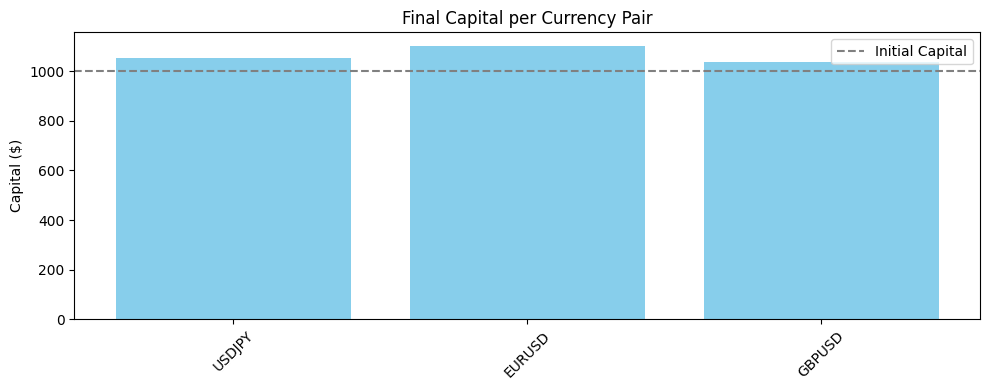

In [17]:
plt.figure(figsize=(10, 4))
plt.bar(clean_names, [capital[p] for p in clean_names], color='skyblue')
plt.axhline(initial_capital, color='gray', linestyle='--', label='Initial Capital')
plt.title('Final Capital per Currency Pair')
plt.ylabel('Capital ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/final_capital_per_pair.png")
plt.show()
